## Required packages

Here,we are going to crawl news website  & anticipate the likelihood of its virality.

In [0]:
!pip install newspaper3k

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from statistics import mean, median
from sklearn import linear_model
from sklearn import discriminant_analysis
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from newspaper import Article  
import csv 
import nltk
#import mechanize
nltk.download('punkt')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Crawling through News  

In [0]:
from bs4 import BeautifulSoup
from requests import get
from newspaper import Article
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
url = 'https://www.ndtv.com/'
response = get(url)
#print(response.text[:1000])


In [0]:
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [0]:
DIV = html_soup.findAll('div', attrs={'class' : 'thumbnail'})
article_links = []
for div in DIV:
    link = div.find('a')['href']
    article_links.append(link)

### Observing an article data obtained by crawling through NDTV news website 

The below is the crawled website data

In [0]:
link = article_links[0]
article = Article(link, language="en")
article.download() 
article.parse()
date =  article.publish_date
article.nlp() 
url = article.url
print('Article in url:\n',url)
title = article.title
print('\nTitle:\n',title)
text = article.text.split('.')
print('\nText:\n','.'.join(text[0:5]))
keywords = article.keywords
print('\nKeywords:\n',keywords)
summary = article.summary
print('\nSummary:\n',summary)



Article in url:
 https://www.ndtv.com/india-news/bulandshahr-2-sadhus-killed-with-sword-at-up-temple-allegedly-by-man-accused-of-theft-2219474?pfrom=home-topstories

Title:
 Uddhav Thackeray Calls Yogi Adityanath Over Murders Of 2 Sadhus In UP

Text:
 Bulandshahr Police: The sadhus were killed at a temple where they were staying temporarily.

Highlights The sadhus, 55 and 35, were killed with a sword last evening

Chief Minister Yogi Adityanath has asked for strict action against killer

Accused had allegedly been raging since the priests accused him of theft

The murder of two sadhus inside a temple at Uttar Pradesh's Bulandshahr has snowballed into a political controversy days after two sadhus were killed by a mob in Maharashtra.

The sadhus, 52 and 35, were killed on Monday night, allegedly by a man they had berated and accused of theft. A man called Raju has been arrested and charged with murder, the police said.

"Raju said he had bhang (cannabis) and went into the temple and murd

# Finding the Features

Here,we are converting the features from our crawled website data and finding the values to fill into respective attributes that uci news dataset has

In [0]:
!pip install datefinder

In [0]:
from textblob import TextBlob
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import datefinder
import datetime 
import calendar 
import random
from statistics import mean

nltk.download('stopwords')
data_set = []
for link in article_links:
    article = Article(link, language="en")
    article.download() 
    article.parse()
    date =  article.publish_date
    article.nlp() 
    title = article.title
    text = article.text
    keywords = article.keywords
    url = article.url
    article_info = {}

    #url
    article_info['url'] = url
    #content
    article_info['content'] = text
    

    #Number of words in the title
    n_tokens_title = len(word_tokenize(title))
    article_info['n_tokens_title'] = n_tokens_title
    #print(n_tokens_title)

    #Number of words in the text
    n_tokens_content = len(word_tokenize(text))
    article_info['n_tokens_content'] = n_tokens_content
    #print(n_tokens_content)

    # list of positive,negative and neutral words in the content
    positive_words_text =[]
    negative_words_text =[]
    neutral_words_text = []
    positive_words_polarity = []
    negative_words_polarity = []
    neutral_words_polarity =[]
    for i in word_tokenize(text):
        p = TextBlob(i)
        if p.sentiment.polarity > 0:
            positive_words_text.append(i)
            positive_words_polarity.append(p.sentiment.polarity)
        elif p.sentiment.polarity < 0:
            negative_words_text.append(i)
            negative_words_polarity.append(p.sentiment.polarity)
        elif i.isalpha():
            neutral_words_text.append(i)
            neutral_words_polarity.append(p.sentiment.polarity)
    if len(positive_words_text) == 0:
        positive_words_text = [0]
    if len(negative_words_text) == 0:
        negative_words_text = [0]
    if len(neutral_words_text) == 0:
        neutral_words_text = [0]
    if len(positive_words_polarity) == 0:
        positive_words_polarity =[0]
    if len(negative_words_polarity) == 0:
        negative_words_polarity = [0]
    if len(neutral_words_polarity) == 0:
        neutral_words_polarity = [0]
    #Rate of unique words in content
    set1 = set(word_tokenize(text))
    n_unique_tokens = len(set1)/n_tokens_content
    article_info['n_unique_tokens'] = n_unique_tokens
    #print(n_unique_tokens)

    #Rate of non-stop words in the content
    english_stops = set(stopwords.words('english'))
    non_stop_words = [word for word in word_tokenize(text) if word not in english_stops]
    n_non_stop_words = len(non_stop_words)/n_tokens_content
    article_info['n_non_stop_words'] = n_non_stop_words
    #print(n_non_stop_words)

    #Rate of unique non-stop words in content
    set1 = set(non_stop_words)
    n_non_stop_unique_tokens = len(set1)/n_tokens_content
    article_info['n_non_stop_unique_tokens'] = n_non_stop_unique_tokens
    #print(n_non_stop_unique_tokens)

    #Average length of the words in the content
    list_text = word_tokenize(text)
    average_token_length = sum(map(len, list_text))/float(len(list_text))
    article_info['average_token_length'] = average_token_length
    #print(average_token_length)

    #Number of keywords in the metadata
    num_keywords = len(keywords)
    article_info['num_keywords'] = num_keywords
    #print(num_keywords)

    #Is data channel ‘Lifestyle’?
    data_channel_is_lifestyle = 1 if((('life-style' or 'life style' or 'health' or 'swirlster') in url) or (('life-style' or 'life style' or 'health') in text.lower()) ) else 0
    article_info['data_channel_is_lifestyle'] = data_channel_is_lifestyle
    #print(data_channel_is_lifestyle)

    #Is data channel ‘Entertainment’?
    data_channel_is_entertainment = 1 if((('movies' or 'entertainment' or 'sports' or 'game') in url) or (('movies' or 'entertainment' or 'sports' or 'game') in text.lower()) ) else 0
    article_info['data_channel_is_entertainment'] = data_channel_is_entertainment
    #print(data_channel_is_lifestyle)

    #Is data channel ‘Business’? 
    data_channel_is_bus = 1 if((('business') in url) or (('business') in text.lower())) else 0
    article_info['data_channel_is_bus'] = data_channel_is_bus
    #print(data_channel_is_bus)

    #Is data channel ‘Social Media’?
    data_channel_is_socmed = 1 if((('social-media'or 'social media' or 'facebook' or 'whatsapp' or 'twitter' or 'instagram' or 'linkedin' or 'reddit') in url) or (('social-media'or 'social media' or 'facebook' or 'whatsapp' or 'twitter' or 'instagram' or 'linkedin' or 'reddit') in text.lower())) else 0
    article_info['data_channel_is_socmed'] = data_channel_is_socmed
    #print(data_channel_is_socmed)

    #Is data channel ‘Tech’?  
    data_channel_is_tech = 1 if((('gadgets' or 'technology' or 'tech') in url) or (('gadgets' or 'technology' or 'tech') in text.lower())) else 0
    article_info['data_channel_is_tech'] = data_channel_is_tech
    #print(data_channel_is_tech)

    #Is data channel ‘World’? 
    data_channel_is_world = 1 if((('world-news') in url) or (('world-news') in text.lower()) or (('world news') in text.lower())) else 0
    article_info['data_channel_is_world'] = data_channel_is_world
    #print(data_channel_is_world)

    #Number of images 
    num_imgs = len(article.images)
    article_info['num_imgs'] = num_imgs

    #Number of videos
    num_videos = len(article.movies)
    article_info['num_videos'] = num_videos

    #Number of links to other articles published by Mashable
    num_hrefs = article.html.count("https://www.ndtv.com/")
    article_info['num_hrefs'] = num_hrefs 

    #finding day
    try:
        matches = datefinder.find_dates(link)
        for match in matches:
            date = match
    except:
        pass
    
    if date:
        day = calendar.day_name[date.weekday()]
    else:
        day = random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    #print(day)

    #Was the article published on a Monday?
    weekday_is_monday = 1 if day == 'Monday' else 0
    article_info['weekday_is_monday'] = weekday_is_monday

    #Was the article published on a Tuesday?
    weekday_is_tuesday = 1 if day == 'Tuesday' else 0
    article_info['weekday_is_tuesday'] = weekday_is_tuesday

    #Was the article published on a Wednesday?
    weekday_is_wednesday = 1 if day == 'Wednesday' else 0
    article_info['weekday_is_wednesday'] = weekday_is_wednesday

    #Was the article published on a Thursday?
    weekday_is_thursday  = 1 if day == 'Thursday' else 0
    article_info['weekday_is_thursday'] = weekday_is_thursday

    #Was the article published on a Friday?
    weekday_is_friday = 1 if day == 'Friday' else 0
    article_info['weekday_is_friday'] = weekday_is_friday

    #Was the article published on a Saturday?
    weekday_is_saturday = 1 if day == 'Saturday' else 0
    article_info['weekday_is_saturday'] = weekday_is_saturday

    #Was the article published on a Sunday?   
    weekday_is_sunday = 1 if day == 'Sunday' else 0
    article_info['weekday_is_sunday'] = weekday_is_sunday

    #Was the article published on the weekend?
    is_weekend = 1 if weekday_is_saturday==1 or weekday_is_sunday==1 else 0
    article_info['is_weekend'] = is_weekend

    text_blob = TextBlob(text)
    title_blob = TextBlob(title)
    #Text subjectivity
    global_subjectivity = text_blob.sentiment.subjectivity
    article_info['global_subjectivity'] = global_subjectivity
    # Text sentiment polarity
    global_sentiment_polarity = text_blob.sentiment.polarity
    article_info['global_sentiment_polarity'] = global_sentiment_polarity


    #Rate of positive words in the content
    global_rate_positive_words = len(positive_words_text)/n_tokens_content
    article_info['global_rate_positive_words'] = global_rate_positive_words
    #Rate of negative words in the content
    global_rate_negative_words = len(negative_words_text)/n_tokens_content
    article_info['global_rate_negative_words'] = global_rate_negative_words
    #Rate of positive words among non-neutral tokens
    rate_positive_words = (len(positive_words_text)/(n_tokens_content-len(neutral_words_text)))
    article_info['rate_positive_words'] = rate_positive_words
    #Rate of negative words among non-neutral tokens
    rate_negative_words =  (len(negative_words_text)/(n_tokens_content-len(neutral_words_text)))
    article_info['rate_negative_words'] = rate_negative_words
    #Avg. polarity of positive words
    avg_positive_polarity= mean(positive_words_polarity)
    article_info['avg_positive_polarity'] = avg_positive_polarity
    #Min. polarity of positive words 
    min_pol_pos = np.array(positive_words_polarity) 
    min_positive_polarity= np.amin(min_pol_pos)
    article_info['min_positive_polarity'] = min_positive_polarity
    #Max. polarity of positive words 
    max_pol_pos = np.array(positive_words_polarity) 
    max_positive_polarity= np.amax(max_pol_pos)
    article_info['max_positive_polarity'] = max_positive_polarity
    #Avg. polarity of negative words 
    avg_negative_polarity =mean(negative_words_polarity)
    article_info['avg_negative_polarity'] = avg_negative_polarity
    #Min. polarity of negative words  
    min_pol_neg = np.array(negative_words_polarity) 
    min_negative_polarity= np.amin(min_pol_neg)
    article_info['min_negative_polarity'] = min_negative_polarity
    #Max. polarity of negative words 
    max_pol_neg = np.array(negative_words_polarity) 
    max_negative_polarity= np.amax(max_pol_neg)
    article_info['max_negative_polarity'] = max_negative_polarity
    #Title subjectivity  
    title_subjectivity  =title_blob.sentiment.subjectivity
    article_info['title_subjectivity'] = title_subjectivity
    #Title polarity
    title_sentiment_polarity =title_blob.sentiment.polarity
    article_info['title_sentiment_polarity'] = title_sentiment_polarity
    data_set.append(article_info)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
final_dataframe = pd.DataFrame(data_set)
final_dataframe.head()

,url,content,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,num_imgs,num_videos,num_hrefs,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity
0,https://www.ndtv.com/india-news/bulandshahr-2-...,Bulandshahr Police: The sadhus were killed at ...,12,625,0.425600,0.657600,0.342400,4.361600,14,0,0,0,0,0,0,11,0,96,0,0,0,1,0,0,0,0,0.247171,-0.047727,0.009600,0.017600,0.056604,0.103774,0.243333,0.1,0.50,-0.250938,-1.0,-0.071429,0.0,0.0
1,https://www.ndtv.com/india-news/no-evidence-to...,"Plasma therapy can even be life threatening, t...",13,396,0.416667,0.671717,0.328283,4.527778,13,0,0,0,0,0,0,15,0,94,0,0,1,0,0,0,0,0,0.426389,0.108788,0.040404,0.007576,0.246154,0.046154,0.224290,0.1,0.75,-0.100000,-0.1,-0.100000,0.0,0.0
2,https://www.ndtv.com/karnataka-news/coronaviru...,They're not permitted to do patrolling which w...,12,319,0.545455,0.614420,0.416928,4.589342,16,0,0,0,0,0,0,12,0,88,0,0,0,0,1,0,0,0,0.227273,-0.022727,0.009404,0.006270,0.060000,0.040000,0.100000,0.1,0.10,-0.200000,-0.3,-0.100000,0.0,0.0
3,https://www.ndtv.com/india-news/coronavirus-lo...,The man started beating up his wife every time...,15,252,0.507937,0.646825,0.376984,4.079365,15,0,0,0,0,0,0,11,0,94,0,0,0,0,0,0,1,1,0.304167,-0.162500,0.003968,0.023810,0.025641,0.153846,0.400000,0.4,0.40,-0.337500,-0.4,-0.125000,0.0,0.0
4,https://sports.ndtv.com/cricket/ramiz-raja-tea...,Ramiz Raja didn't mince any words as he lashed...,14,588,0.425170,0.736395,0.345238,4.164966,13,0,0,0,0,0,0,55,0,0,0,0,0,0,1,0,0,0,0.462276,0.025884,0.025510,0.023810,0.093168,0.086957,0.438667,0.1,0.80,-0.378571,-0.8,-0.100000,0.0,0.0


## Training a Model to predict virality 

Here,we took uci dataset for news virality prediction and trained randomforest regressor to predict virality of the uci news dataset.Here,we are taking ucinews dataset as train data and our crawled website data as test data.For the test data,we are using the model randomforestregressor to estimate the likelihood.The more the likelihood of news article is closer to 1,the more likely it is to become viral

The below is the uci news website data,the data is contained in a file named uci_news_data.csv

In [0]:
from google.colab import files
uploaded = files.upload()
import io
data = pd.read_csv(io.BytesIO(uploaded['uci_news_data.csv']))

data.head()

Saving uci_news_data.csv to uci_news_data.csv


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731,12,219,0.663594,1.0,0.815385,4,2,1,0,4.680365,5,0,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,496,496,496.000000,1,0,0,0,0,0,0,0,0.500331,0.378279,0.040005,0.041263,0.040123,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0.0
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731,9,255,0.604743,1.0,0.791946,3,1,1,0,4.913725,4,0,0,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.000000,1,0,0,0,0,0,0,0,0.799756,0.050047,0.050096,0.050101,0.050001,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0.0
2,http://mashable.com/2013/01/07/apple-40-billio...,731,9,211,0.575130,1.0,0.663866,3,1,1,0,4.393365,6,0,0,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,918,918,918.000000,1,0,0,0,0,0,0,0,0.217792,0.033334,0.033351,0.033334,0.682188,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1.0
3,http://mashable.com/2013/01/07/astronaut-notre...,731,9,531,0.503788,1.0,0.665635,9,0,1,0,4.404896,7,0,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.000000,1,0,0,0,0,0,0,0,0.028573,0.419300,0.494651,0.028905,0.028572,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0.0
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.415646,1.0,0.540890,19,19,20,0,4.682836,7,0,0,0,0,1,0,0,0,0.0,0,0,0.0,0.0,0.0,0.0,545,16000,3151.157895,1,0,0,0,0,0,0,0,0.028633,0.028794,0.028575,0.028572,0.885427,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0.0


In [0]:
first_df = data.copy()

In [0]:
# drop rows with ANY NaN
#df = df.dropna(axis=0, thresh=df.shape[1])
first_df = first_df.dropna(thresh=first_df.shape[1])

first_df.head()
first_df.isna().sum()

url                             0
timedelta                       0
n_tokens_title                  0
n_tokens_content                0
n_unique_tokens                 0
                               ..
title_subjectivity              0
title_sentiment_polarity        0
abs_title_subjectivity          0
abs_title_sentiment_polarity    0
shares                          0
Length: 61, dtype: int64

In [0]:
first_df.shape

(4534, 61)

In [0]:
first_df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

The following features can be dropped:
url: URL of the article (non-predictive)
timedelta: Days between the article publication and the dataset acquisition (non-predictive)
five LDA variables
is_weekend, since it seems to be duplicating days of week
kw_min_min, kw_avg_min, kw_min_avg have a number of negative values
and also we dropped several other features that are not significant in estimating the likelihood of viralty of news

In [0]:
first_df = first_df.drop(['LDA_00','LDA_01', 'LDA_02', 'LDA_03', 'LDA_04','num_self_hrefs', 'kw_min_min', 'kw_max_min', 'kw_avg_min','kw_min_max','kw_max_max','kw_avg_max','kw_min_avg','kw_max_avg','kw_avg_avg','self_reference_min_shares','self_reference_max_shares','self_reference_avg_sharess','abs_title_subjectivity','abs_title_sentiment_polarity'],axis=1)
first_df.head()


,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731,12,219,0.663594,1.0,0.815385,4,1,0,4.680365,5,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.521617,0.092562,0.045662,0.013699,0.769231,0.230769,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.0
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731,9,255,0.604743,1.0,0.791946,3,1,0,4.913725,4,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.341246,0.148948,0.043137,0.015686,0.733333,0.266667,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.0
2,http://mashable.com/2013/01/07/apple-40-billio...,731,9,211,0.575130,1.0,0.663866,3,1,0,4.393365,6,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.702222,0.323333,0.056872,0.009479,0.857143,0.142857,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,1.0
3,http://mashable.com/2013/01/07/astronaut-notre...,731,9,531,0.503788,1.0,0.665635,9,1,0,4.404896,7,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0.429850,0.100705,0.041431,0.020716,0.666667,0.333333,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.0
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731,13,1072,0.415646,1.0,0.540890,19,20,0,4.682836,7,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0.513502,0.281003,0.074627,0.012127,0.860215,0.139785,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.0


In [0]:
print(first_df.shape)
print(final_dataframe.shape)

(4534, 41)
(136, 40)


Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_imgs',
       'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'avg_negative_polarity', 'min_negative_polarity',
       'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='

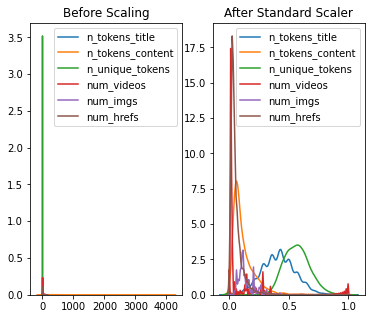

48
0.6012134562261168


In [0]:
#first 2 columns are meta data, not used for training
df = first_df.drop(['url','timedelta'],axis=1)
scaler = MinMaxScaler()
print(df.columns)
X=df.drop('shares', axis=1)

X[X.columns] = scaler.fit_transform(X[X.columns])

y=df['shares']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['n_tokens_title'], ax=ax1)
sns.kdeplot(df['n_tokens_content'], ax=ax1)
sns.kdeplot(df['n_unique_tokens'], ax=ax1)
sns.kdeplot(df['num_videos'], ax=ax1)
sns.kdeplot(df['num_imgs'], ax=ax1)
sns.kdeplot(df['num_hrefs'], ax=ax1)
ax2.set_title('After Standard Scaler')

sns.kdeplot(X['n_tokens_title'], ax=ax2)
sns.kdeplot(X['n_tokens_content'], ax=ax2)
sns.kdeplot(X['n_unique_tokens'], ax=ax2)
sns.kdeplot(X['num_videos'], ax=ax2)
sns.kdeplot(X['num_imgs'], ax=ax2)
sns.kdeplot(X['num_hrefs'], ax=ax2)
plt.show()

svd = TruncatedSVD(n_components=10)
arr = svd.fit_transform(X)
arr = pd.DataFrame(arr)
new_X = pd.concat([X, arr], axis=1)
#new_X[new_X.columns] = scaler.fit_transform(new_X[new_X.columns])

train_X, test_X, train_y, test_y = train_test_split(new_X, y, train_size=0.25, random_state=123)

model = RandomForestRegressor(max_depth=10, random_state=0) #model to predict virality

model.fit(train_X, train_y)
print(len(model.feature_importances_))

y_pred = model.predict(test_X)
print(roc_auc_score(test_y, y_pred))


## Prediction of Virality

Here,we calculated the likelihood(probability) that the news will become viral based on the features and based on the model we used for trained dataset and we are using our webcrawled dataset as a test dataset for the same model.

In [0]:
url_df = final_dataframe['url']
content_df = final_dataframe['content']

scaler = MinMaxScaler()
X1=final_dataframe.drop(['url','content'],axis=1)
X1[X1.columns] = scaler.fit_transform(X1[X1.columns])
svd1 = TruncatedSVD(n_components=5)
arr1 = svd.fit_transform(X1)
arr1 = pd.DataFrame(arr1)
new_X1 = pd.concat([X1, arr1], axis=1)

result = model.predict(new_X1)
result = pd.DataFrame(result,columns=['likelihood_of_Virality'])
Output_dataframe = pd.concat([url_df,content_df, result],axis=1)

Below,we can see that the url,content and likelihood are printed.The more the likelihood of virality,the more chance it has to become viral

In [0]:
Output_dataframe.head(10)

,url,content,likelihood_of_Virality
0,https://www.ndtv.com/india-news/bulandshahr-2-...,Bulandshahr Police: The sadhus were killed at ...,0.640599
1,https://www.ndtv.com/india-news/no-evidence-to...,"Plasma therapy can even be life threatening, t...",0.630152
2,https://www.ndtv.com/karnataka-news/coronaviru...,They're not permitted to do patrolling which w...,0.446485
3,https://www.ndtv.com/india-news/coronavirus-lo...,The man started beating up his wife every time...,0.578973
4,https://sports.ndtv.com/cricket/ramiz-raja-tea...,Ramiz Raja didn't mince any words as he lashed...,0.493649
5,https://www.carandbike.com/news/coronavirus-im...,The Coronavirus pandemic has meant that the wo...,0.539965
6,https://www.ndtv.com/world-news/coronavirus-br...,"With Singapore under partial lockdown, people ...",0.684793
7,https://www.ndtv.com/world-news/kim-jong-un-to...,Kim Jong Un's absence from an event has sparke...,0.590199
8,https://gadgets.ndtv.com/telecom/news/airtel-n...,Finnish network equipment maker Nokia has secu...,0.563343
9,https://www.ndtv.com/world-news/covid-19-updat...,Donald Trump threatened to seek damages from C...,0.594575


# **Summary**

> Here,we have two datasets,one is crawled news dataset and the other is uci nnews dataset.

> Here,we are using random forest regressor to estimate the likelihood of virality of news.

> We are using uci news dataset as train dataset and that is trained using randomforest regressor and we are using crawled news dataset as test dataset

> The more the likelihood of virality is close to 1,the more the news has the capacity to become viral








